# SP500: Up or Down
Using daily market movement of the S&P500 over 20 years, can we predict the next day movement?

In [30]:
library(RcppRoll)
library(MASS)
library(klaR)
library(e1071)
library(caret)
library(zoo)
library(xts)
library(magrittr)
library(lubridate)
library(tidyverse)
options(warn=-1)

In [4]:
# Loading the data set
sp500 <- read_csv("sp500_20y.csv")
colnames(sp500) <- tolower(make.names(colnames(sp500)))
head(sp500,3)

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Open = col_double(),
  High = col_double(),
  Low = col_double(),
  Close = col_double(),
  `Adj Close` = col_double(),
  Volume = col_double()
)


date,open,high,low,close,adj.close,volume
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1999-06-14,1293.64,1301.99,1292.20,1294.00,1294.00,669400000
1999-06-15,1294.00,1310.76,1294.00,1301.16,1301.16,696600000
1999-06-16,1301.16,1332.83,1301.16,1330.41,1330.41,806800000


_Create additional feature columns from the daily movement. Here we will look at two, three, four consecutive days up and down._

In [5]:
# percent change and number of consecutive days up or down

sp500_20y <- sp500 %>% 
    select(date, adj.close) %>% 
    mutate(# %change from prior day
           pct.chg = (lag(adj.close) - adj.close) / (adj.close),
           # up two consecutive days
           up2cd = case_when(lag(pct.chg, 1) > 0 & 
                                 pct.chg > 0  ~ 1, 
                             T ~ 0),
           # up three consecutive days
           up3cd = case_when(lag(pct.chg, 2) > 0 & 
                                  lag(pct.chg, 1) > 0 & 
                                  pct.chg > 0 ~ 1,
                              T ~ 0),
           # up four consecutive days
           up4cd = case_when(lag(pct.chg, 3) > 0 & 
                                  lag(pct.chg, 2) > 0 & 
                                  lag(pct.chg, 1) > 0 & 
                                  pct.chg > 0 ~ 1,
                              T ~ 0),
           # down two consecutive days
           dn2cd = case_when(lag(pct.chg, 1) < 0 & 
                           pct.chg < 0  ~ 1, 
                             T ~ 0),
           # down up three consecutive days
           dn3cd = case_when(lag(pct.chg, 2) < 0 & 
                                  lag(pct.chg, 1) < 0 & 
                                  pct.chg < 0 ~ 1,
                              T ~ 0),
           # down up four consecutive days
           dn4cd = case_when(lag(pct.chg, 3) < 0 &
                                  lag(pct.chg, 2) < 0 & 
                                  lag(pct.chg, 1) < 0 & 
                                  pct.chg < 0 ~ 1,
                              T ~ 0)) %>% drop_na() 
head(sp500_20y)

date,adj.close,pct.chg,up2cd,up3cd,up4cd,dn2cd,dn3cd,dn4cd
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1999-06-15,1301.16,-0.005502808,0,0,0,0,0,0
1999-06-16,1330.41,-0.021985703,0,0,0,1,0,0
1999-06-17,1339.90,-0.007082611,0,0,0,1,1,0
1999-06-18,1342.84,-0.002189347,0,0,0,1,1,1
1999-06-21,1349.00,-0.004566371,0,0,0,1,1,1
1999-06-22,1335.88,0.009821238,0,0,0,0,0,0


_We are going to add additional features. The selections are arbitrary for the most part._
- 10 year treasure bond rate
- cattle futures
- coffee price
- copper price
- crude oil futures
- lumber futures
- US dollars futures
- VIX

In [7]:
# Reading in all the files within the features folder and joining tables

files <- list.files(path = "features", pattern = "*.csv", full.names = T)
df_list <- map(files, read_csv)
for(i in 1:length(df_list)){
    df_list[[i]] <- df_list[[i]]  %>% mutate(date = mdy(date))
}
for(i in 2:length(df_list)){
    df_list[[1]] <- full_join(df_list[[1]], df_list[[i]], by = "date") 
}

features <- df_list[[1]] 
sp500_features <- left_join(sp500_20y, features, by = "date")

# count missing in each column

sp500_features %>% map_df(~sum(is.na(.)))

Parsed with column specification:
cols(
  date = col_character(),
  treasury_bond = col_double()
)
Parsed with column specification:
cols(
  date = col_character(),
  cattle = col_double()
)
Parsed with column specification:
cols(
  date = col_character(),
  coffee = col_double()
)
Parsed with column specification:
cols(
  date = col_character(),
  copper = col_double()
)
Parsed with column specification:
cols(
  date = col_character(),
  crude_oil = col_double()
)
Parsed with column specification:
cols(
  date = col_character(),
  lumber = col_double()
)
Parsed with column specification:
cols(
  date = col_character(),
  us_dollar = col_double()
)
Parsed with column specification:
cols(
  date = col_character(),
  vix_adj_close = col_double()
)


date,adj.close,pct.chg,up2cd,up3cd,up4cd,dn2cd,dn3cd,dn4cd,treasury_bond,cattle,coffee,copper,crude_oil,lumber,us_dollar,vix_adj_close
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,34,20,22,36,17,28,0,0


In [8]:
# impute missing values and cleaning up

pchg <- function(x){(lag(x) - x) / (x)}

sp500_features <- sp500_features %>% 
    # impute missing values linearly
    map_dfc(~na.approx(.)) %>% 
    # make factors
    mutate_at(c(4:9), as.factor) %>% 
    # drop unused columns
    select(-c(1:2)) %>%
    # drop rows with NAs due to day pct change
    drop_na()
head(sp500_features)
# count missing in each column
sp500_features %>% map_df(~sum(is.na(.)))

pct.chg,up2cd,up3cd,up4cd,dn2cd,dn3cd,dn4cd,treasury_bond,cattle,coffee,copper,crude_oil,lumber,us_dollar,vix_adj_close
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.005502808,0,0,0,0,0,0,5.98,64.67,1.0395,0.6325,18.550,383.1,101.90,25.91
-0.021985703,0,0,0,1,0,0,5.94,64.72,1.0530,0.6295,17.940,384.7,102.50,22.40
-0.007082611,0,0,0,1,1,0,5.79,64.00,1.0535,0.6325,18.234,394.7,102.18,21.95
-0.002189347,0,0,0,1,1,1,5.84,63.87,1.0590,0.6540,18.066,404.7,102.00,21.75
-0.004566371,0,0,0,1,1,1,5.90,63.52,1.0350,0.6600,17.826,400.4,102.55,21.81
0.009821238,0,0,0,0,0,0,5.94,63.70,1.0555,0.6640,17.722,398.1,102.69,21.70


pct.chg,up2cd,up3cd,up4cd,dn2cd,dn3cd,dn4cd,treasury_bond,cattle,coffee,copper,crude_oil,lumber,us_dollar,vix_adj_close
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# checking correlation between the features

(sp500_features_cor <- cor(sp500_features[-c(1:7)], use = "complete.obs"))

,treasury_bond,cattle,coffee,copper,crude_oil,lumber,us_dollar,vix_adj_close
treasury_bond,1.00000000,-0.7986127,-0.54874436,-0.5713150,-0.45559606,-0.09507288,0.40147518,0.1410227
cattle,-0.79861269,1.0000000,0.59203572,0.6324710,0.52904421,0.22559238,-0.38233500,-0.3471870
coffee,-0.54874436,0.5920357,1.00000000,0.7748369,0.70455457,-0.06279907,-0.64771351,-0.1044770
copper,-0.57131502,0.6324710,0.77483693,1.0000000,0.87498539,0.04437540,-0.77140466,-0.2694983
crude_oil,-0.45559606,0.5290442,0.70455457,0.8749854,1.00000000,-0.02649801,-0.82485426,-0.1655707
lumber,-0.09507288,0.2255924,-0.06279907,0.0443754,-0.02649801,1.00000000,0.06717727,-0.5547478
us_dollar,0.40147518,-0.3823350,-0.64771351,-0.7714047,-0.82485426,0.06717727,1.00000000,0.1075843
vix_adj_close,0.14102269,-0.3471870,-0.10447699,-0.2694983,-0.16557067,-0.55474778,0.10758434,1.0000000


Warning message:
"package 'ggcorrplot' was built under R version 3.5.3"

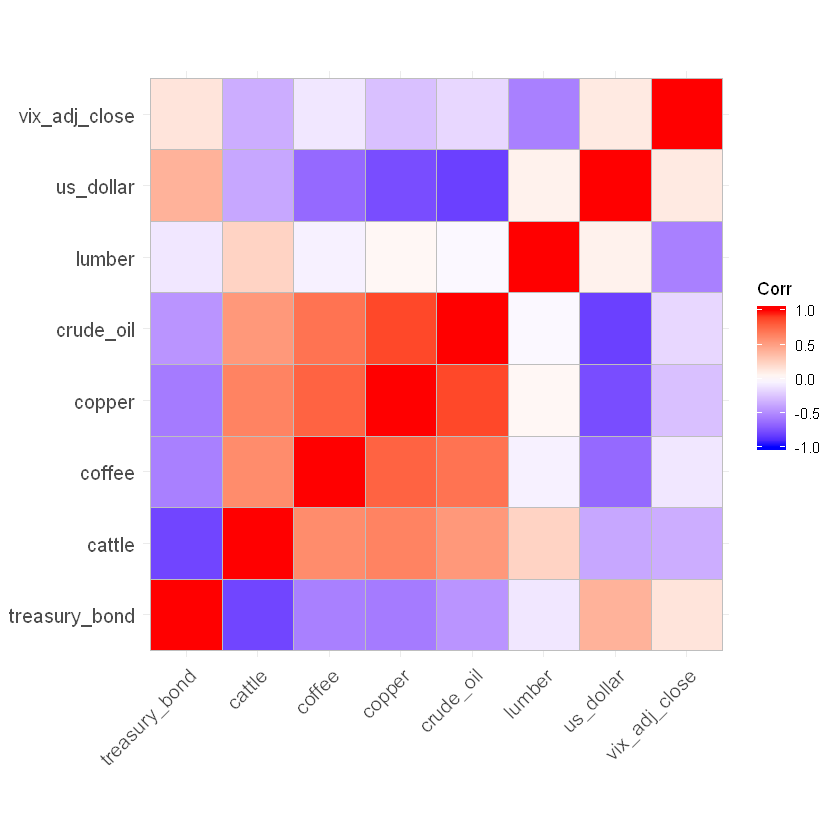

In [10]:
library(ggcorrplot)
ggcorrplot(sp500_features_cor)

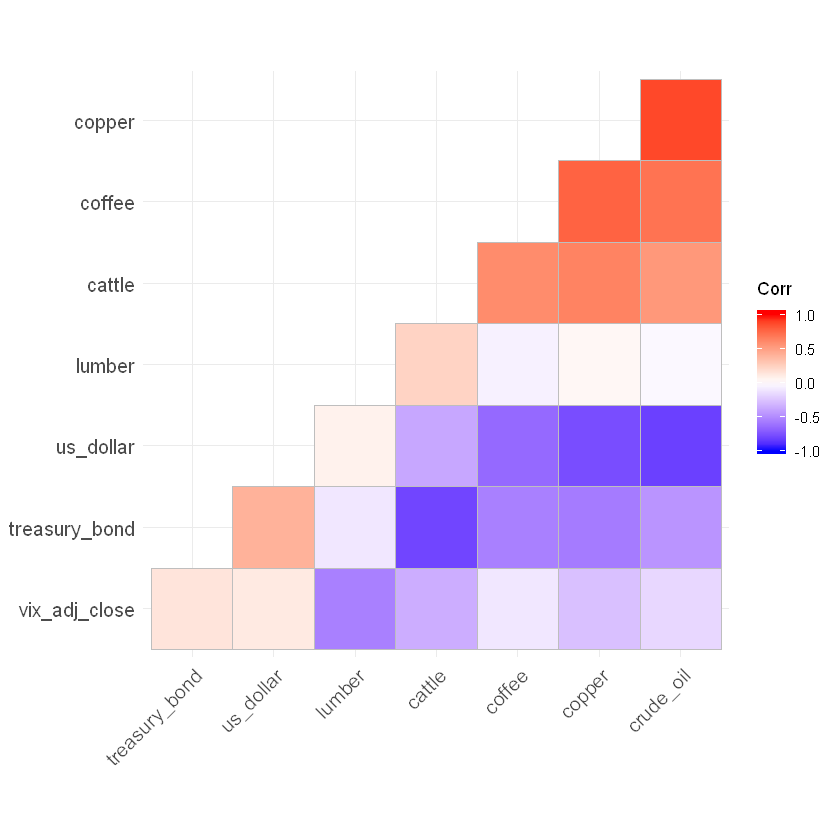

In [12]:
# hierarchical clustering on the correlation matrix

cor_clust <- ggcorrplot(sp500_features_cor, hc.order = TRUE, type = "lower")
cor_clust

In [13]:
# perform principal component analysis (PCA) with standardizing

(sp500_features_pca <- prcomp(sp500_features[-c(1:7)], scale = T))

Standard deviations (1, .., p=8):
[1] 2.0655447 1.2751701 0.9481567 0.6530746 0.5706768 0.4625475 0.3834322
[8] 0.3087333

Rotation (n x k) = (8 x 8):
                      PC1         PC2         PC3         PC4         PC5
treasury_bond -0.35598328  0.08491205 -0.62317548  0.08528642 -0.32263594
cattle         0.38212585 -0.22403786  0.46759719  0.12245115  0.03349426
coffee         0.40874055  0.15423913  0.02599982  0.04554149 -0.83391448
copper         0.45175143  0.05994080 -0.17328277  0.03400607 -0.02448049
crude_oil      0.42575230  0.15723938 -0.30216813 -0.08539729  0.17825044
lumber         0.04890698 -0.68093071 -0.14927718 -0.69913574 -0.14911633
us_dollar     -0.38762729 -0.21646515  0.38721213  0.20225874 -0.37328649
vix_adj_close -0.14898226  0.61641411  0.31429252 -0.66144495 -0.07361951
                       PC6         PC7          PC8
treasury_bond  0.386882145 -0.41271712 -0.215260839
cattle         0.392132793 -0.61550790 -0.190802224
coffee        -0.287939862 

In [14]:
library(FactoMineR)
sp500_features_pca_out <- PCA(sp500_features[-c(1:7)], scale.unit = T, ncp = 3, graph = F)
sp500_features_pca_out$eig

Warning message:
"package 'FactoMineR' was built under R version 3.5.3"

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,4.26647482,53.330935,53.33094
comp 2,1.62605881,20.325735,73.65667
comp 3,0.89900116,11.237515,84.89418
comp 4,0.42650643,5.331330,90.22552
comp 5,0.32567205,4.070901,94.29642
comp 6,0.21395022,2.674378,96.97079
comp 7,0.14702023,1.837753,98.80855
comp 8,0.09531627,1.191453,100.00000


In [15]:
summary(sp500_features_pca_out)


Call:
PCA(X = sp500_features[-c(1:7)], scale.unit = T, ncp = 3, graph = F) 


Eigenvalues
                       Dim.1   Dim.2   Dim.3   Dim.4   Dim.5   Dim.6   Dim.7
Variance               4.266   1.626   0.899   0.427   0.326   0.214   0.147
% of var.             53.331  20.326  11.238   5.331   4.071   2.674   1.838
Cumulative % of var.  53.331  73.657  84.894  90.226  94.296  96.971  98.809
                       Dim.8
Variance               0.095
% of var.              1.191
Cumulative % of var. 100.000

Individuals (the 10 first)
                  Dist    Dim.1    ctr   cos2    Dim.2    ctr   cos2    Dim.3
1             |  3.688 | -3.188  0.047  0.747 |  0.454  0.003  0.015 |  0.706
2             |  3.640 | -3.132  0.046  0.740 |  0.739  0.007  0.041 |  0.791
3             |  3.623 | -3.070  0.044  0.718 |  0.863  0.009  0.057 |  0.784
4             |  3.685 | -3.058  0.044  0.689 |  0.962  0.011  0.068 |  0.846
5             |  3.710 | -3.124  0.045  0.709 |  0.929  0.011  0.06

In [16]:
sp500_features_pca_out$eig[1:3,]
# variance = pc.vector * cor.matrix * pc.vector.transpose

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,4.2664748,53.33094,53.33094
comp 2,1.6260588,20.32574,73.65667
comp 3,0.8990012,11.23751,84.89418


In [17]:
head(sp500_features)

pct.chg,up2cd,up3cd,up4cd,dn2cd,dn3cd,dn4cd,treasury_bond,cattle,coffee,copper,crude_oil,lumber,us_dollar,vix_adj_close
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.005502808,0,0,0,0,0,0,5.98,64.67,1.0395,0.6325,18.550,383.1,101.90,25.91
-0.021985703,0,0,0,1,0,0,5.94,64.72,1.0530,0.6295,17.940,384.7,102.50,22.40
-0.007082611,0,0,0,1,1,0,5.79,64.00,1.0535,0.6325,18.234,394.7,102.18,21.95
-0.002189347,0,0,0,1,1,1,5.84,63.87,1.0590,0.6540,18.066,404.7,102.00,21.75
-0.004566371,0,0,0,1,1,1,5.90,63.52,1.0350,0.6600,17.826,400.4,102.55,21.81
0.009821238,0,0,0,0,0,0,5.94,63.70,1.0555,0.6640,17.722,398.1,102.69,21.70


In [18]:
sp500_features_pca_out_full <- PCA(sp500_features, 
                                   quali.sup = c(2:7),
                                   quanti.sup = c(1),
                                   ncp = 3, 
                                   scale.unit = T,
                                   graph = F)

In [88]:
# Train, Test Split

ndata = nrow(sp500_features)
split = .8
ntrain = floor(ndata * split)
ntest = floor(ndata * (1-split))
idxtrain = seq(1:ntrain)

sp500_features.train <- sp500_features[idxtrain,]
print(head(sp500_features.train))
paste0("Number of rows in training: ", nrow(sp500_features.train))

sp500_features.test <- sp500_features[-idxtrain,]
print(head(sp500_features.test))
paste0("Number of rows in test: ", nrow(sp500_features.test))

# A tibble: 6 x 15
   pct.chg up2cd up3cd up4cd dn2cd dn3cd dn4cd treasury_bond cattle coffee
     <dbl> <fct> <fct> <fct> <fct> <fct> <fct>         <dbl>  <dbl>  <dbl>
1 -0.00550 0     0     0     0     0     0              5.98   64.7   1.04
2 -0.0220  0     0     0     1     0     0              5.94   64.7   1.05
3 -0.00708 0     0     0     1     1     0              5.79   64     1.05
4 -0.00219 0     0     0     1     1     1              5.84   63.9   1.06
5 -0.00457 0     0     0     1     1     1              5.9    63.5   1.03
6  0.00982 0     0     0     0     0     0              5.94   63.7   1.06
# ... with 5 more variables: copper <dbl>, crude_oil <dbl>, lumber <dbl>,
#   us_dollar <dbl>, vix_adj_close <dbl>


[1] "Number of rows in training: 4026"

# A tibble: 6 x 15
   pct.chg up2cd up3cd up4cd dn2cd dn3cd dn4cd treasury_bond cattle coffee
     <dbl> <fct> <fct> <fct> <fct> <fct> <fct>         <dbl>  <dbl>  <dbl>
1 -5.66e-3 0     0     0     0     0     0              2.32   151.   1.29
2 -1.98e-3 0     0     0     1     0     0              2.32   151.   1.27
3 -9.81e-3 0     0     0     1     1     0              2.35   149.   1.29
4  5.33e-3 0     0     0     0     0     0              2.26   151.   1.27
5 -6.06e-3 0     0     0     0     0     0              2.37   152.   1.30
6 -6.35e-4 0     0     0     1     0     0              2.42   152.   1.28
# ... with 5 more variables: copper <dbl>, crude_oil <dbl>, lumber <dbl>,
#   us_dollar <dbl>, vix_adj_close <dbl>


[1] "Number of rows in test: 1007"

In [89]:
# Train the pcr model with 3 principal components

pcr.model <- train(pct.chg ~ . , data=sp500_features.train, 
                   preProcess = c("center", "scale"),
                   method = "pcr", scale = T)
# model results
print(pcr.model)
summary(pcr.model)

Principal Component Analysis 

4026 samples
  14 predictor

Pre-processing: centered (14), scaled (14) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 4026, 4026, 4026, 4026, 4026, 4026, ... 
Resampling results across tuning parameters:

  ncomp  RMSE        Rsquared     MAE        
  1      0.01261350  0.004647481  0.008454663
  2      0.01166678  0.148496057  0.007747604
  3      0.01163746  0.152808692  0.007716288

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was ncomp = 3.
Data: 	X dimension: 4026 14 
	Y dimension: 4026 1
Fit method: svdpc
Number of components considered: 3
TRAINING: % variance explained
          1 comps  2 comps  3 comps
X         33.2075    51.54    63.83
.outcome   0.4102    14.95    15.46


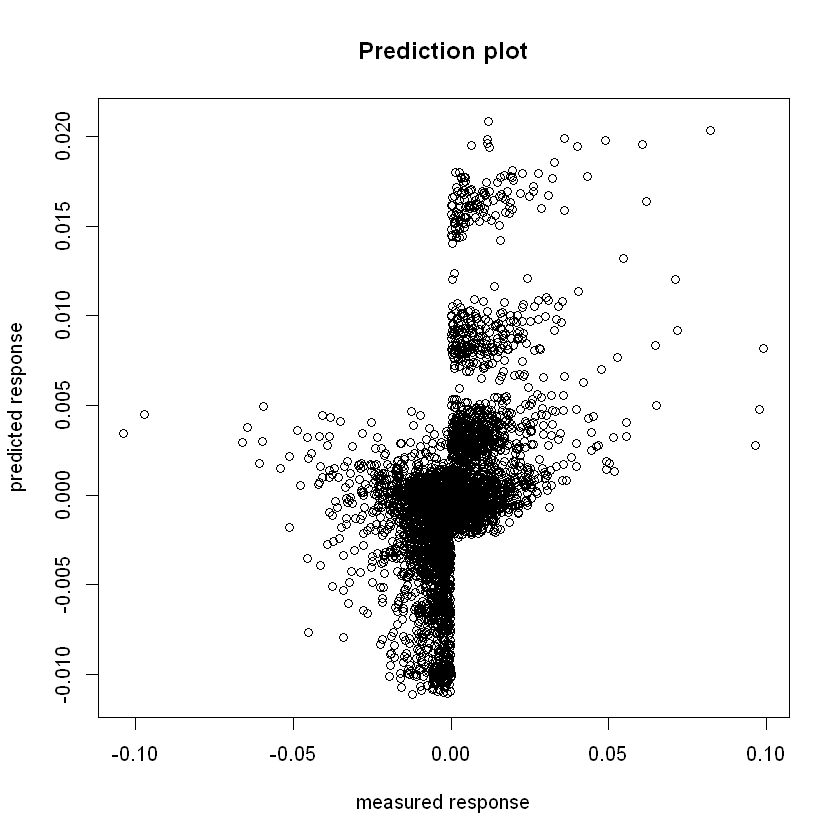

In [90]:
predplot(pcr.model)

In [130]:
# test model

sp500_features.predict <- predict(pcr.model, newdata = sp500_features.test)
sp500_pcr.out <- data.frame(test.values = sp500_features.test[[1]],
           pred.values = sp500_features.predict)

# adjusted R-squared for test set
# (expected to be poor)
mean((sp500_features.predict - sp500_features.test[[1]])^2)

# check

sp500_pcr.out %>% 
    mutate(
        test.move = case_when(test.values > 0 ~ 1, T ~ 0),
        pred.move = case_when(pred.values > 0 ~ 1, T ~ 0)) %>% 
    summarize(correct = sum(test.move == pred.move), 
              total = n(), 
              accuracy = mean(test.move == pred.move))

[1] 6.346269e-05

correct,total,accuracy
<int>,<int>,<dbl>
745,1007,0.7398213


In [93]:
pc_df <- data.frame(sp500_features_pca_out_full$ind$coord)
sp500.pc <- sp500_features %>% 
    select(1:7) %>% 
    mutate(move = as.factor(case_when(pct.chg > 0 ~ 1, T ~ 0))) %>% 
    select(8,2:7)
sp500.pc <- bind_cols(sp500.pc, pc_df)
str(sp500.pc)

Classes 'tbl_df', 'tbl' and 'data.frame':	5033 obs. of  10 variables:
 $ move : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 2 2 2 1 ...
 $ up2cd: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 2 2 1 ...
 $ up3cd: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 2 2 1 ...
 $ up4cd: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 2 1 ...
 $ dn2cd: Factor w/ 2 levels "0","1": 1 2 2 2 2 1 1 1 1 1 ...
 $ dn3cd: Factor w/ 2 levels "0","1": 1 1 2 2 2 1 1 1 1 1 ...
 $ dn4cd: Factor w/ 2 levels "0","1": 1 1 1 2 2 1 1 1 1 1 ...
 $ Dim.1: num  -3.19 -3.13 -3.07 -3.06 -3.12 ...
 $ Dim.2: num  0.454 0.739 0.863 0.962 0.929 ...
 $ Dim.3: num  0.706 0.791 0.784 0.846 0.852 ...


In [95]:
# Train and test sets 

sp500.pc.train <- sp500.pc[idxtrain,]
print(head(sp500.pc.train))
paste0("Number of rows in training: ", nrow(sp500.pc.train))

sp500.pc.test <- sp500.pc[-idxtrain,]
print(head(sp500.pc.test))
paste0("Number of rows in test: ", nrow(sp500.pc.test))

# A tibble: 6 x 10
  move  up2cd up3cd up4cd dn2cd dn3cd dn4cd Dim.1 Dim.2 Dim.3
  <fct> <fct> <fct> <fct> <fct> <fct> <fct> <dbl> <dbl> <dbl>
1 0     0     0     0     0     0     0     -3.19 0.454 0.706
2 0     0     0     0     1     0     0     -3.13 0.739 0.791
3 0     0     0     0     1     1     0     -3.07 0.863 0.784
4 0     0     0     0     1     1     1     -3.06 0.962 0.846
5 0     0     0     0     1     1     1     -3.12 0.929 0.852
6 1     0     0     0     0     0     0     -3.12 0.910 0.861


[1] "Number of rows in training: 4026"

# A tibble: 6 x 10
  move  up2cd up3cd up4cd dn2cd dn3cd dn4cd Dim.1 Dim.2 Dim.3
  <fct> <fct> <fct> <fct> <fct> <fct> <fct> <dbl> <dbl> <dbl>
1 0     0     0     0     0     0     0      1.19 0.879 -1.50
2 0     0     0     0     1     0     0      1.19 0.944 -1.44
3 0     0     0     0     1     1     0      1.22 1.01  -1.34
4 1     0     0     0     0     0     0      1.21 0.984 -1.45
5 0     0     0     0     0     0     0      1.24 1.03  -1.39
6 0     0     0     0     1     0     0      1.21 1.04  -1.37


[1] "Number of rows in test: 1007"

## Naive Bayes

In [96]:
# use caret package to define tuning
# use a 10-fold cross-validation repeated 10 times

train.control <- trainControl(method = "repeatedcv", number = 10, repeats = 10)

# Train the model using the training set with 10-fold cv
nb.classifier <- train(move ~ ., data = sp500.pc.train, 
                       method = "nb", trControl = train.control)

# Summarize the results
print(nb.classifier)

Naive Bayes 

4026 samples
   9 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 3623, 3623, 3623, 3622, 3624, 3624, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE            NaN        NaN
   TRUE      0.7340079  0.4806808

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1.


In [97]:
# Training set accuracy

nb.predict <- predict(nb.classifier, newdata = sp500.pc.train)
confusionMatrix(data = nb.predict, sp500.pc.train$move)

# Test set accuracy

nb.predict <- predict(nb.classifier, newdata = sp500.pc.test)
confusionMatrix(data = nb.predict, sp500.pc.test$move)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1169   85
         1  976 1796
                                        
               Accuracy : 0.7365        
                 95% CI : (0.7226, 0.75)
    No Information Rate : 0.5328        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.4856        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.5450        
            Specificity : 0.9548        
         Pos Pred Value : 0.9322        
         Neg Pred Value : 0.6479        
             Prevalence : 0.5328        
         Detection Rate : 0.2904        
   Detection Prevalence : 0.3115        
      Balanced Accuracy : 0.7499        
                                        
       'Positive' Class : 0             
                                        

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 323  52
         1 218 414
                                         
               Accuracy : 0.7319         
                 95% CI : (0.7034, 0.759)
    No Information Rate : 0.5372         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.4738         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.5970         
            Specificity : 0.8884         
         Pos Pred Value : 0.8613         
         Neg Pred Value : 0.6551         
             Prevalence : 0.5372         
         Detection Rate : 0.3208         
   Detection Prevalence : 0.3724         
      Balanced Accuracy : 0.7427         
                                         
       'Positive' Class : 0              
                                         

## GLM (Generalized Linear Model)

In [98]:
# Train the model using training set
glm.classifier <- train(move ~ ., data = sp500.pc.train, 
                    method = "glm", family = "binomial",
                    trControl = train.control)
# Summarize the results
print(glm.classifier)

# Test model
glm.predict <- predict(glm.classifier, newdata = sp500.pc.test)
summary(glm.predict)

# performance of test
sp500.pc.test %>% 
    mutate(glm.pred = glm.predict) %>% 
    summarize(correct = sum(move == glm.pred), 
              total = n(), 
              accuracy = mean(move == glm.pred))

Generalized Linear Model 

4026 samples
   9 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 3623, 3623, 3623, 3624, 3623, 3623, ... 
Resampling results:

  Accuracy  Kappa    
  0.715771  0.4279155



0   1 
756 251

correct,total,accuracy
<int>,<int>,<dbl>
746,1007,0.7408143


## RPART (Recursive Partitioning And Regression Trees)

In [99]:
# Train the model using training set with 10-fold cv
rpart.classifier <- train(move ~ ., data = sp500.pc.train, 
                    method = "rpart", 
                    trControl = train.control, tuneLength = 10)
# Summarize the results
print(rpart.classifier)

CART 

4026 samples
   9 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 3624, 3624, 3624, 3623, 3624, 3623, ... 
Resampling results across tuning parameters:

  cp            Accuracy   Kappa    
  0.0005316321  0.7047983  0.4094815
  0.0007974482  0.7050222  0.4100499
  0.0010632642  0.7046481  0.4088361
  0.0013290803  0.7069308  0.4131700
  0.0015948963  0.7087686  0.4183673
  0.0021265284  0.7145580  0.4315592
  0.0023923445  0.7166685  0.4355122
  0.0024303182  0.7166685  0.4355122
  0.0027910686  0.7187792  0.4409763
  0.4343434343  0.6317608  0.2409289

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.002791069.


In [100]:
rpart.predict <- predict(rpart.classifier, newdata = sp500.pc.test)
# performance of test
sp500.pc.test %>% 
    mutate(rpart.pred = rpart.predict) %>% 
    summarize(correct = sum(move == rpart.pred), 
              total = n(), 
              accuracy = mean(move == rpart.pred))

correct,total,accuracy
<int>,<int>,<dbl>
744,1007,0.7388282


## GBM (Generalized Boosted Regression Models)

In [101]:
library(gbm)
# Train the model using the training set with 10-fold cv
gbm.classifier <- train(move ~ ., data = sp500.pc.train, verbose = FALSE,
                       method = "gbm", trControl = train.control)
# Summarize the results
print(gbm.classifier)

Stochastic Gradient Boosting 

4026 samples
   9 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 3624, 3623, 3623, 3623, 3623, 3623, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.7277466  0.4481153
  1                  100      0.7001461  0.3971093
  1                  150      0.6956481  0.3886105
  2                   50      0.7047922  0.4069800
  2                  100      0.6942352  0.3859148
  2                  150      0.6900150  0.3776121
  3                   50      0.6965680  0.3898654
  3                  100      0.6895940  0.3764810
  3                  150      0.6885009  0.3742893

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
Accuracy was used to select the optimal model using the largest value.
The final v

In [102]:
gbm.predict <- predict(gbm.classifier, newdata = sp500.pc.test)
# performance of test
sp500.pc.test %>% 
    mutate(gbm.pred = gbm.predict) %>% 
    summarize(correct = sum(move == gbm.pred), 
              total = n(), 
              accuracy = mean(move == gbm.pred))

correct,total,accuracy
<int>,<int>,<dbl>
741,1007,0.7358491


## LDA (Linear Discriminant Analysis)

In [103]:
# LDA is mainly used for multi-class classification
# However, we'll try it anyways.

library(MASS)

# Train the model using the training set with 10-fold cv
lda.classifier <- train(move ~ ., data = sp500.pc.train, 
                       method = "lda", trControl = train.control)
# Summarize the results
print(lda.classifier)

Linear Discriminant Analysis 

4026 samples
   9 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 3623, 3623, 3623, 3624, 3623, 3623, ... 
Resampling results:

  Accuracy   Kappa    
  0.7161721  0.4285429



In [104]:
lda.predict <- predict(lda.classifier, newdata = sp500.pc.test)
# performance of test
sp500.pc.test %>% 
    mutate(lda.pred = lda.predict) %>% 
    summarize(correct = sum(move == lda.pred), 
              total = n(), 
              accuracy = mean(move == lda.pred))

correct,total,accuracy
<int>,<int>,<dbl>
746,1007,0.7408143
